# NOTEBOOK (#1): DATA EXPLANATION, CLEANING & PREPARATION

# TABLE OF CONTENTS

* Part One [Data Cleaning, Preparation & Explanation] (#PART_ONE)

* Part Two [Calculating PECDS (PAR EQUIVALENT CREDIT DEFAULT SWAP](#PART_TWO)

* Part Three [Descriptive Statistics Overview](#PART_THREE)

* Part Four [Regressions & Modelling]


* May wish to seperate out these sections into 4 seperate notebooks? 

In [ ]:
#look at appending bond trading data / CDS trading data to see if the constant issue with the cds spread == no trades? 

In [ ]:
#import six
#six.MAXSIZE

In [ ]:
#import potential packages needed

In [1]:
#system packages

import sys
import warnings
import os 
import traceback #obs? 
if not sys.warnoptions:
    warnings.filterwarnings("once")  

In [2]:
#base packages:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats, integrate, optimize
import math
import datetime
from datetime import date, timedelta

In [3]:
#optional packages

from statsmodels.tsa.base.datetools import dates_from_str
from IPython.display import display
pd.options.display.max_columns = 30  #allow DF.head to show all columns in notebook
from see import see
from tabulate import tabulate 
#from io import StringIO

In [4]:
#packages for the econometrics / models

from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron, ZivotAndrews
from arch.unitroot.cointegration import engle_granger, phillips_ouliaris
import statsmodels.formula.api as smf  #VAR package contained within 
import statsmodels.tsa.api as smt

#import the functionality for detecting mathematical errors (E.G. types of linear algebra issues etc.)
from statsmodels.tools.sm_exceptions import ValueWarning
from arch.utility.exceptions import (
    InfeasibleTestException,
    InvalidLengthWarning,
    invalid_length_doc)
warnings.filterwarnings("once", category = ValueWarning)

C:\Users\JasonSpano\anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [5]:
#pickle file: 
#sorted_alldata_df_final = pd.read_pickle("./sorted_alldata_df_final.pkl")

sorted_alldata_df_final = pd.read_pickle(r"C:\Users\JasonSpano\OneDrive\Uva Msc 19-20 Subjects\Research Assistant Docs\CDS_project_-_first_set_of_tasks\Part 2_jan20./sorted_alldata_df_final.pkl")

In [ ]:
# to do: 
#4.11.2020: 
#clean up ZA test by (changing from C to CL + constant + trend)


fix ZA test: purge the exception in-DF print 
comment on the low std_dev of the groups

#email tomislav? ds skill + code publication + low stddev dropping? / unchronological / time-breaks etc. 
time breaks attributable to the "changing bond-code? happens when merging on GVKEY" - byproduct of long-horizon testing?

#create some ratio of: first-last date / total period? to see "structural breaks"

#fix the loop issue with ADF / other tests

#compare ratio of error groups to groupby(sector) ratio of total DF
#[check main file for the code?]


## Table of Contents

1) Data Overview & Data Cleaning Process

# Section 1.1) Data Overview

1) First data point is a .txt file (~10GB) of Bond Data, downloaded from Wharton Research/Data Services (WRDS): pertaining to TRACE bond trades for all regular bonds (senior bonds with fixed or zero coupons) issued by firms in Compustat. Observations are at the day-level
    * contains all bond trades between 2002 and June-2017
    * Data included is bond ID, cusip_id, exact trade date/time, traded price, quoted_yield
    
2) Second data point is Bond Maturities information (From TRACE) .txt file from WRDS, relating to the corresponding data on bond maturities seniority etc.
    * contains bond ID, cusip_id, sub-product type, debt-type, issuer_name, maturity date, grade, convertible_flag, company_symbol
    
3) Third data point is Bond Coupon Rates,  a .txt file from (Mergent FISD), pertaining to coupon information per bond
    * contains: issue_id, coupon_type, offering_date, principal, first_interest_date, interest_frequency, coupon, day_count_basis, last_interest_date
    
4) Fourth data entry is information extracted from Fred, relating to information on swap_rates from one-year through to five-year (the risk-free rate proxy in this report)- all denonted in USD; in addition to values of VIX and other interest rate components

5) Fifth data entry is the trace-mergent linkfile (provides a common factor to merge bond coupon rae information with bond market prices and bond maturities)
    * contains: bond_ID, issue_id, issue_id_fisd
    * This file is necessary to merge together the data about the bonds as WRDS has data on coupons, maturities, prices from different sub-vendors who potentially use different codes/reference numbers. This file will enable us to merge all of the above information on bonds and eventually, with their respective Credit Default Swap (CDS) counterparts. 
    
6) Sixth date entry is CDS spreads (From Datastream) .txt file (>20GB) of CDS trades on the same date range as the earlier bond information. Only CDS with standard contractual clauses are considered. Observations are at the day-level
    * contains information on: series_id, gvkey, company_name, stock_ticker, source, duration, clause, currency, class_type, date, cds_spread
    
7) (By earlier filtered viable GVKEY sub-sample) Equivalent Equity trading data (Daily) from WRDS/Compustat (CSV ~1GB)
    * Includes: open, high, low, close, trading_volume......

8) (By earlier filtered viable GVKEY sub-sample)(Data is monthly/quarterly level) of: Firm-level ratios
    * pertaining to: EPS....
    
9) Equity Sector Data & Returns (Daily-level) from WRDS/Compustat     

10) (By earlier filtered viable GVKEY sub-sample) detailed breakdown of opening, high, low, closing bond-trades data


#### SIDENOTE: Additional robustness checks will be performed on the same data but re-sampled by weekly/monthly - these DFs will be based off the final DF which includes the merging of all the above dataframes (#1 through #10) but re-sampled respectively.

11) weekly_resample_df

12) monthly_resample_df
    

## Example of importing bond trading data from (.txt) file -- 
### Data is imported from WRDS (Wharton)

* NOTE: only the price is required from this, as the equivalent "yield" will be formulated through another mathematical procedure "par equivalent credit default swap (PECDS)" as the raw yield here is not directly comparable with CDS spreads


* Given data will be collapsed to the daily-level (one trade per bond, per day) - thus, the trade_time variable is not needed. However, it could be incorporated if some intraday trading phenomena became part of the analysis in future studies. 


* Variables definitions: 
    * bond_sym_id == the "ticker" of the bond instrument
    * date == date the trade took place
    * trade_time == the exact time / date
    * quantity == the volume (amount of bonds) traded at that respective trade_time / date
    * price == price paid per bond
    * _yield == simple reported yield (quoted yield / price)
    


In [ ]:
#BOND DATA: DATA_FILE_#1

bond_file = open('sample_bond_data_all.txt','r')                #read the file (adjust the local directory if necessary)
bonds_date_price = {}                                           #initalise a dictionary to write to

for line in bond_file:  
  line = line.rstrip("\r\n")  
  #for each line, strip the whitespace characters [new line, return key etc.]
    
  [bond_sym_id, date, trade_time, quantity, price, _yield] = line.split("\t")    
  #for each variable [bond_sym_id, date etc.] split on the [tab] space  

  if bond_sym_id=="bond_sym_id" and date=='date':               #this forms the "break point" between bonds/trading days
    continue
    
  #try to update the initial dictionary with the respective bond, for each date, with the traded price for that time  
  #note: (value error was rarely- that is, (less than) 25 instances encountered, usually missing or corrupted data points)  
    
  try:
      bonds_date_price[(date, bond_sym_id)] = price
  except ValueError as ve:
    print("ValueError: Row: {}, Reason : {} ".format(line, ve))   #print the location/details of any encountered value errors
    
    
#construct the final DF with the necessary items, label the columns    
bonds_date_price_df = pd.DataFrame(list(bonds_date_price.items()), columns=['date','date_id_price'])

#close the file
bond_file.close()

In [ ]:
#Create a datetime object for later merging this data with the relevant swap_rates / other data
#this is because the date column imported is not yet recognised as date format in Python: 

format_date = '%Y%m%d'                                                                #American style date
datetime_obj = bonds_date_price_df['trade_date'].apply(lambda x: datetime.datetime.strptime(x, format_date))


## E.G. Importing the master file (Bond Maturities etc.)

* Many of the subsequent data imports share a near identical format to the first block of code; consequently, the code is included without annotations

In [ ]:
bond_file= open('master_file.txt','r')
bond_maturities = {}

for line in bond_file:  
  line = line.rstrip("\r\n") 
  [bond_sym_id, cusip_id, bsym_id, sub_prdct_type, debt_type_cd, issuer_nm, scrty_ds, cpn_rt, cpn_type_cd, trd_rpt_efctv_dt, mtrty_dt, grade, ind_144a, dissem, cnvrb_fl, company_symbol] = line.split("\t")
  if bond_sym_id=="bond_sym_id":
    continue
    
  try:
      bond_maturities[(bond_sym_id)] = mtrty_dt
  except ValueError as ve:
    print("ValueError: Row: {}, Reason : {} ".format(line, ve))       

bond_maturities_df = pd.DataFrame(list(bond_maturities.items()), columns=['bond_sym_id','maturity_date'])    
bond_file.close()

In [ ]:
#matched with the first file by bond_ID

In [ ]:
coupon_file= open('coupon_info.txt','r')
coupons_dict = {}

#change to include the location in the try/except loop

for line in coupon_file:  
  line = line.rstrip("\r\n")
  [ISSUE_ID, MATURITY, COUPON_TYPE, OFFERING_DATE, PRINCIPAL_AMT, FIRST_INTEREST_DATE,
   INTEREST_FREQUENCY, COUPON, DAY_COUNT_BASIS, LAST_INTEREST_DATE] = line.split("\t")
  if ISSUE_ID=="ISSUE_ID":
    continue
  try:
      coupons_dict[(ISSUE_ID, INTEREST_FREQUENCY, COUPON)] = ISSUE_ID, INTEREST_FREQUENCY, COUPON
  except ValueError:
    pass

try:
    coupons_df = pd.DataFrame(list(coupons_dict.items()), columns=['ISSUE_ID','INTEREST_FREQ'])
except RuntimeError as re:
    print("runtime error", re)
except Exception as other:
    print("something else", other)
 
coupon_file.close()

In [ ]:
#RFR DATA

In [ ]:
from fredapi import Fred
fred = Fred(api_key='56e2cc23702c09f0c02226f2780c4de4') #censor this code eventually

In [ ]:
#SWAP RATES



get from older version 


In [ ]:
#LINEAR INTERPOLATION OF THE RFRs

#interpolate / line-broken for readability
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 'riskfree_rate_5yr']] = 
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 'riskfree_rate_5yr']].interpolate(method='linear',limit_direction='forward')

#method = linear; consecutive NaN(s) are filled forward; axis = 1, (interpolation occurs down the columns )

## VIX / TED SPREAD 
* SOURCE: FRED

In [ ]:
#VIX series
cboe_vix = fred.get_series('VIXCLS', '2006-07-03','2017-06-30')

#TEDRATE
ted_rate = fred.get_series('TEDRATE', '2006-07-03','2017-06-30')

#concatenate the two series column-wise
int_spreads_concat = pd.concat([cboe_vix, ted_rate],axis=1)

#convert to a dataframe
interest_spreads_df = pd.DataFrame(int_spreads_concat.values, 
                                   index=cboe_vix.index,
                                  columns=['cboe_vix','ted_rate'])

#interpolate the DF (linearly) any missing values in the: VIX or TED rates
interest_spreads_df[['cboe_vix','ted_rate']] = interest_spreads_df[['cboe_vix','ted_rate']].interpolate(method='linear',limit_direction='forward')

In [ ]:
#check both series have zero NaN(s)
interest_spreads_df.isna().sum()

In [ ]:
#reset the index of the DF so that the trade-date becomes a seperate column (to allow merging onto the main bond/cds DF)
interest_spreads_df = interest_spreads_df.reset_index()

#rename the relevant columns:
interest_spreads_df = interest_spreads_df.rename(columns={'index':'trade_date'})

In [ ]:
#check d-types (datetime64 for trade/date and float64 for values)
print(interest_spreads_df.dtypes)

### Merge this DF onto the main dateframe with the firm-level data
* set the main-DF as the principal DF, such that a left merge on trade-date will only keep the relevant dates for each firm
* that is, E.G. if Firm(X) has data from 2010:2014, only the interest_spreads from 2010:2014 will be affixed for this firm 

In [ ]:
#E.G. of the merge: 
fulldata_daily_vix_df = fulldata_daily_df.merge(interest_spreads_df, how='left', on='trade_date')

In [ ]:
#trace_mergent_linkfile.txt
merge_file= open('trace_mergent_linkfile.txt','r')
merge_dict = {}

for line in merge_file:  
  line = line.rstrip("\r\n")
  [bond_sym_id, issue_id_fisd] = line.split("\t")
  if bond_sym_id=="bond_sym_id":
    continue
  try:
      merge_dict[bond_sym_id, issue_id_fisd] = bond_sym_id, issue_id_fisd
  except ValueError:
    pass

try:
    mergefile_df = pd.DataFrame(list(merge_dict.items()), columns=['bond_sym_id','issue_id_fisd'])
except (RuntimeError, TypeError, NameError):
    print('ERROR')
     
merge_file.close()

In [ ]:
#CDS SPREAD

cds_file = open('sample_cds_data_all.txt','r')
cds_spread_dict = {}

for line in cds_file:  
  line = line.rstrip("\r\n") 
  [series_id, series_name, gvkey, company_name, ticker, source, duration, clause, currency, class_type, date, cds_spread] = line.split("\t")   
  if series_id=="series_id":
    continue
  if (float(duration)==5 and currency=="USD" and clause=="XR"):
    cds_spread_dict[gvkey, series_id, date] = cds_spread #date removed 
    
cds_file.close()

try: 
    cds_spread_df2 = pd.DataFrame(list(cds_spread_dict.items()),columns = ['cds_info','cds_spread']) 
except RuntimeError as re:
    print("runtime error", re)
except Exception as other:
    print("something else", other)

# DATAFRAME (#8) - FIRM LEVEL RATIOS
#### E.G. of ratios contained within & outlining what the Wharton abreviations actually represent: 

* #bm = book/market
* #pe_inc = P/E (Diluted, Incl. EI)
* #ps = price/sales
* #p/cf = Price/Cash flow	
* #npm = net profit margin
* #roe = return on equity 
* #Gprof = Gross profit / Total Assets
* #Capital_ratio = Capitalization ratio
* #fcf_ocf = Free Cash Flow/Operating Cash Flow
* #de_ratio = Total Debt/Equity
* #curr_ratio = current ratio 
* #rd_sale = Research and Development/Sales
* #ptb = price to book
* #divyield = dividend yield 

#### NOTE: due to the inherently different nature of the included firms, it is expected that there will be (Null) values in each ratio per firm, E.G. not all firms will pay a dividend and thus dividend_yield will be 0.

In [ ]:
firm_level_ratios = 'firm_level_ratios_gvkey.csv'
firm_level_ratio_df = pd.read_csv(firm_level_ratios)

In [ ]:
#because of the .CSV file, the dtypes won't be compatible with the existing pandas-based DF
#principally, the date series (for merging onto the main DF) will need to be converted to datetime from string

#convert the float64 column to datetime
#in Wharton: the series for which the ratio was released as public information is referred to as 'public_date'
firm_level_ratios_dtime = pd.to_datetime(firm_level_ratio_df['public_date'], format='%Y%m%d', errors='coerce')

#rename this column to match 'trade_date' so it can be merged 
firm_level_ratios_dtime = firm_level_ratios_dtime.rename(columns={"public_date": "trade_date"})

## Overcoming a major issue: different frequencies of reporting, as ratios per firm are reported either monthly, or quarterly:
* Need to devise a method to interpolate the values between these two points in time and transform it to daily-level values so some series can later be used in the various models, E.G. Vector Autoregressions 
* Also, need to make sure the method cuts the time periods correctly for each firm-combination, as virtually every firm-combination has a unique set of start and finish dates for its CDS/BOND data series: both for accuracy and to reduce computation strain 

In [ ]:
#also noted that we will need to merge by [GVKEY, DATE] now and thus GVKEY needs to be converted from (object) type
firm_level_ratios_dtime['gvkey'] = firm_level_ratios_dtime['gvkey'].astype(np.int)

In [ ]:
#create a seperate date column which is just the month:year and leave the daily-level series unaffected
firm_level_ratios_dtime['trade_date_month'] = firm_level_ratios_dtime['trade_date']

#convert to date-time, the level of the ratios data is at minimum (month:year)
firm_level_ratios_dtime['trade_date_month'] = pd.to_datetime(firm_level_ratios_dtime['trade_date_month'], format='%Y-%m')

#create a pivot-tabel of those value-series deemed relevant for the later regression models
df_firm_ratios_mini = firm_level_ratios_dtime.pivot(index='trade_date_month', columns='gvkey',
                                                     values=['ps','pcf','GProf','capital_ratio','de_ratio','rd_sale'])

#now, create the offsets for the DF's dates: 
start_date = df_firm_ratios_mini.index.min() - pd.DateOffset(day=1)    #note: "trade_date_month" is now the index column
end_date = df_firm_ratios_mini.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'

#ffill will pad the values in-between the two dates to create a continuous flow E.G. January 1, 2,... 31st etc.
pivot_df_firm_ratios_mini = df_firm_ratios_mini.reindex(dates, method='ffill') 

In [ ]:
#now, need to rearrange the pivot-DF back to a regular format by stacking the DF on the GVKEY
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.stack('gvkey')

#sort the DF, so that each GVKEY is sorted chronologically
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.sort_index()

#reset the index, so that this chronologically sorted date-series is now treated as a column within the DF (for easier merging)
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.reset_index()

In [ ]:
#Optional: create a pickle of this particular set of variables, 
#if it is required to change the input-series for a different set of values

pivot_df_firm_ratios_mini.to_pickle("./pivot_df_firm_ratios_mini.pkl")
#pivot_df_firm_ratios_mini = pd.read_pickle("./pivot_df_firm_ratios_mini.pkl")  #would be read-pickle code

In [ ]:
#now, the final merge to re-affix the now converted/padded values of firm-level ratios on a daily level to the main DF
#optional to rename DF to modified version, e.g. fulldata_df_ratios to confirm the ratios are correctly formatted now

fulldata_df = fulldata_df.merge(pivot_df_firm_ratios_mini, how='left', on=['gvkey','trade_date'])

# DATAFRAME (#9) DAILY EQUITY PRICES / TRADING INDICATORS

In [ ]:
#DVRATED -- Indicated Annual Dividend Rate - Daily
#curcdd = CURCDD -- ISO Currency Code - Daily
#cshoc = CSHOC -- Shares Outstanding
#cshtrd = CSHTRD -- Trading Volume - Daily
#eps = EPS -- Current EPS
#prccd = PRCCD -- Price - Close - Daily
#prchd = PRCHD -- Price - High - Daily
#prcld = PRCLD -- Price - Low - Daily
#prcod = PRCOD -- Price - Open - Daily
#exchg = Stock Exchange Code	 #19 = other-OTC US, 12 = Amaerican, 14 = NASDAQ, 11 = NYSE
#secstat = Security Status Market	 I = inactive, A= active
#costat = COSTAT -- Active/Inactive Status Marker

# = GSUBIND -- GIC Sub-Industries
#Global Industry Classification Standard (GICS). The Sub-industry is represented by all 8 digits of the total GICS code.

#idbflag = IDBFLAG -- International, Domestic, Both Indicator (B = North-America & Int, D = domestic (NA), I = int)
#spicindcd = SPCINDCD -- S&P Industry Sector Code

In [ ]:
daily_us_equity_prices = 'gvkey_daily_usa_equity_prices.csv'
daily_us_equity_prices_df = pd.read_csv(daily_us_equity_prices)

### Given this data is already at the daily-level by GVKEY, the process to merge it onto the main-DF is virtually identical to the processes outlined above. Hence, it has been omitted here to avoid needless repitition 

In [ ]:
#the one thing to note here is to ensure that you keep only the one trading observation for prices per day:
#E.G. after converting the date to datetime, renaming columns, checking for Null/NaN etc.

daily_us_equity_prices_df = daily_us_equity_prices_df.drop_duplicates(subset=['gvkey','trade_date'], keep='first')

# Breakingdown the data merging process:

* I dropped all bonds with missing or negative prices (assume this is an error in the data on the vendor's end as it is implausible to have a negatively priced bond); repeated this step with other important data points, such as: missing coupon rates or maturity dates. 
    * Out of 10M + total observations, only a few thousand were dropped in this manner so the data integrity as whole is sound. 
    * Around 10% of the bonds have no data on interest_frequency (frequency of the coupon payments, usually semi-annual for most fixed-rate bonds); this issue is elaborated on more in one of the next steps


* Multiple approaches in merging, I believe a fairly simple method is to perform an outer-join on the BOND & CDS data frames; thus, potentially there will be some observations with bond prices and no CDS spreads, and vice-versa. However, quickly dropping the NaN from the DF will resolve this, resulting in a DF with just the overlapping firms with both CDS and BOND data. 



In [ ]:
#th

## Restricting the aggregate DF to only those firms with both a CDS:Bond trading between 4-6 years
* First, calculate the time gap between date traded (From the original bond trade file) and the maturity date by bond_ID (from the 2nd data entry file on bond maturities)- to filter the DF to only those observatios beteen four and six years

In [ ]:
#Convert the maturity date column to more workable datetime format for the later date(1) - date(2) calculation 
fulldata_df['maturity_date'] = pd.to_datetime(fulldata_df['maturity_date'], format="%Y%m%d", errors='coerce')

#Extract the existing dates within the index as seperate column to simplify the subsequent calculation
fulldata_df['time_dif'] = ((fulldata_df['maturity_date'] - fulldata_df['trade_date']))

In [ ]:
#filter sample to keep only observations for which both a CDS-Bond combination exist with maturities between 4-6 years

#pre-create the variables to hold the date limits (note, 1Y == 365.2425 days)
fouryear_timedelta = timedelta(days=(365.2425 * 4))
sixyear_timedelta = timedelta(days=(365.2425 * 6))

#first, restrict to only maturities less than 6 years
fulldata_df = fulldata_df[fulldata_df['time_dif'] < pd.Timedelta(sixyear_timedelta, unit='d')]

#further filter to only those maturities greater than 4 years; resulting in a range of 4-6Y
fulldata_df = fulldata_df[fulldata_df['time_dif'] > pd.Timedelta(fouryear_timedelta, unit='d')]


In [ ]:
#improve the readability of the dataframe above by converting the days to years
#fill NaN or missing values with 0 days

fulldata_df['time_dif'] = (fulldata_df['time_dif'] / np.timedelta64(1, 'Y')).fillna(pd.Timedelta('0 Days'))

#optional but recommended: round the large float value for a more compact, readable DF
fulldata_df['time_dif'] = np.round(fulldata_df['time_dif'], 3)

# Basic Data Cleaning & Preparation

* Checking for NaN / Missing / Duplicated Values

In [ ]:
#after merging all of the previous data into one aggregate frame
#note: pickles of the intermediate data sets (E.G. just equities / bonds / cds, without ratios) exist for faster computation
#although, pandas can handle a 1.34m row dataframe without much effort so this is largely unnecessary

fulldata_df = pd.read_table('full_dataset.txt')  
# ROWS = 13445375 

fulldata_df = fulldata_df[fulldata_df['bond_sym_id'].notna()] #remove the NaN in the bond_sym_id series
# total rows from (13445375) to 11202753

fulldata_df = fulldata_df[fulldata_df['cds_spread'].notna()] #drop NaN from CDS_spread
# total rows from 11202753 to 5495942

### Inspecting a DF of the NaN / Missing values revealed that there were a few corrupted data points with {} in place of the data
* There were 31 instances of corrupted data points
* Also noted several thousand NaN in the (bond) interest/coupon frequency; however, these require seperate considerations

In [ ]:
#find all the occurences of the corrupted data points with: {} instead of price (#NO = 31)
corrupted_price_df = fulldata_df[fulldata_df.price.str.contains('\{}')==True]

#send the index numbers to a list
corrupted_indexes = corrupted_price_df.index.tolist()

#find the loc of these indexs so faciliate dropping them from the DF 
corrupted_indexloc = []
for i in corrupted_indexes:
    corrupted_indexloc.append(fulldata_df.index.get_loc(i))
    

In [ ]:
#drop all of the rows with the corrupted {} in place of the price for the entire DF: based off their index.loc list above
fulldata_df = fulldata_df.drop(fulldata_df.index[corrupted_indexloc], axis=0)

### A feature of the data is missing interest_frequency data points; these cannot simply be dropped as they potentially represent either: zero-coupon bonds, bonds which for whatever reason (perhaps near bankruptcy and undergoing debt deorganisation) have temporarily ceased paying coupons
* These points must be accounted for in the subsequent code to calculate their par-equivalent CDS spreads & how this might affect the results as a whole

In [ ]:
#inspect coupon_freq NaN(s)
missing_ir_freq = fulldata_df[fulldata_df['interest_frequency'].isna()]
missing_ir_freq

#revealed 47219 instances of missing coupon frequency data

## MAJOR PROBLEM: NON-CHRONOLOGICALLY SORTED DATA

### Some data appears to have become jumbled in the sorting, as the index was set to an arbitrary counter (1, 2...., 450K etc.) and Python has recognised that number (E.G. from the screen shot below, 451434 is greater than 100224) and thus, these data points are appearing in chronological order only up to a certain point

    * This is potentially a side-effect of multiple mergings
    * E.G. screenshot below

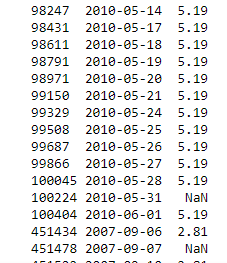

In [ ]:
#in most recent document, no? 

#from msvecm_thesis_1.02

In [ ]:
#create a copy in case the sorting results in an error:
unsorted_fulldata_df = fulldata_df.copy()

#re-organise the DF by (GVKEY) and then sort chronologically on the trade_date
unsorted_fulldata_df = unsorted_fulldata_df.set_index(['gvkey','trade_date']).sort_index()

#reset the index to move GVKEY and trade_date back to regular columns, while preserving the now chronologically sorted format
unsorted_fulldata_df = unsorted_fulldata_df.reset_index()

## optional but recommended: manually inspect a specific GVKEY ##
gvkey_28272 = unsorted_fulldata_df.loc[unsorted_fulldata_df.gvkey==28272]

#print the slice of the DF to string (so it prints the entire thing, and quickly confirm the trade_date is chronological)
print(gvkey_28272[['gvkey','trade_date']].to_string())   

#delete this sliced DF if it's correct and proceed:
del gvkey_28272

#if it is indeed correct, rename the DF / re-copy / or re-run the above code with "fulldata_df" instead
fulldata_df = unsorted_fulldata_df.copy()

#delete the tester DF
del unsorted_fulldata_df

In [ ]:
#now interpolation: 

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward',axis=0)

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward', limit=20, axis=0)
#add in limit to == 10 days

# A note on interpolation

In [ ]:
#interpolation?

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward', limit=20, axis=0)

#interpolate the price  to sales ratio per GVKEY group 
sorted_alldata_df_final = sorted_alldata_df_final.groupby(['gvkey','price_sales']).apply(lambda g: g.interpolate(method='linear',
                                                                                       limit_direction='forward',
                                                                                       limit=4,
                                                                                       axis=0))

#if this were for weekly data: limit == 4 would exclude the interpolation of any series with a structural break >1m time


# Conclusion on the data cleaning process: 


* The result is roughly 408 firms with outstanding CDS contrats, bonds which mature in 4-6 years, as well as have information available on the bonds coupons 

## TIME RE-SAMPLING EXAMPLE
* Going from daily-level observations to weekly; with the week being classified as Wednesday-to-Wednesday to iron out anomalies with Friday-Monday trading phenomena

In [ ]:
fulldata_df_weekly = fulldata_df.groupby('gvkey').resample('W-WED', on='trade_date').first()

#will result in a multi-level index; personal preference to reset index to move ['GVKEY','trade_date'] back to the columns

<a id='PART_TWO'></a>

# PART TWO: Calculating Par-Equivalent Credit Default Swap (PECDS) 

* This is a technique used to be able to compare bonds (even those trading far from par) with their equivalent CDS contracts

### A brief primer on the underlying mechanics and mathematics of PECDS

* Intended to..

#### Initial Class Function:


* NOTE: the "hypothetical_bond_price" returned from this function, is the hypothetically implied price of the bond if the initial (starting value guessed) hazard rate (AKA default rate) were indeed the true hazard rate being used in the market.


* Provided that it is unlikely this initial guess is actually the true hazard rate, the hypothetical bond price variable in itself has no meaning until the subsequent function which re-optimises the entire processs with the newly solved hazard rate. 


* The price given by the solve_for_lambda function, would ...

In [ ]:
class lambda_exp_solver:
    def __init__(self, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr):
        self.coupon = float(coupon) / 100                             
        self.interest_frequency = int(float(interest_frequency))      # must be read in as (int(float( )) to avoid error
        self.maturity = float(years_to_maturity)                           
        self.price = float(price)                                  
        self.riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        self.riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        self.riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        self.riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        self.riskfree_rate_5yr = float(riskfree_rate_5yr) / 100     
        
    #formulate function for expected (present value) of bond- as a function of the numerically optimised hazard_rate (lambda)
    def lambda_bond_price_equation(self, hazard_r):
        
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0          
        
        #initalise fixed parameters: the floating is simply for consistency if debugging is required: 
        principal = float(100)                                       #bonds quoted on basis of principal == $100
        recovery_rate = float(0.4)                                   #equivalent to 0.4 == (1 - RR)
        
        #initialise the class function's self.params
        maturity = self.maturity
        coupon_frequency = self.interest_frequency                  
        coupon_r = self.coupon
        price = self.price                                           
        riskfree_rate_1yr = self.riskfree_rate_1yr
        riskfree_rate_2yr = self.riskfree_rate_2yr
        riskfree_rate_3yr = self.riskfree_rate_3yr
        riskfree_rate_4yr = self.riskfree_rate_4yr
        riskfree_rate_5yr = self.riskfree_rate_5yr
        
        #initialise the risk-free rates as if they were 'one' series, to allow the correct year reference for discounting cash flows
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            ## Next shorten duration of final year by time period between coupon payments 
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            #assuming the math.ceil(mat) means 3.8 >> 4.0; this should ensure the remaining duration is always positive for that 1/2 year's worth of coupon
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop segment handles any issue with negative (remaining_duratuin_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop when the if-clause hits this
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments 
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):                  
                
            ## Obtain risk free rate corresponding to year of bond payment
            # The try/except format is to counter a "key error" occuring with some bonds nearing 6Y maturities - this is resolved by reverting the reference for maturities > 5Y to the 5Y swap rate
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]  
                #note: in python, reference loc[4] is actually referring to the (5 year) swap rate - not the 4th
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:            #occurs with zero-coupon bonds; simply fix zero-coupon bonds to have just one coupon (only the final year)
                    #This resolves the issue with zero-coupon bonds, as this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            ## this is because most bonds pay semi-annual coupons (a select few pay quarterly, but the code will handle either without further changes)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            ## Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year)
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t+= 1
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. 
            ## Note this value is incremented only once (as there can only be one 'final' payoff obviously)
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)                  
                
        ## After looping over all payment years, calculate expected present value of bond          
        hypothetical_bond_price = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default       
    
        ## Return total expected present value
        return hypothetical_bond_price
    
    #the above (lambda_bond_price_equation) function can now be numerically solved by np.optimize
    #this will yield the necessary hazard rate (implied by the market prices/variables) which would set the bond's value to par ($100)
    def solve_for_lambda(self):                                     
        optimised_lambda = optimize.fsolve(self.lambda_bond_price_equation, x0 = 0.05) #note: x0 = initial starting guess parameter - largely arbitrary but 5% is a safe choice
        return optimised_lambda[0]

### Multiple methods for applying the above function to the Bond/CDS dataframe

* Due to the underlying functionality of the optimise function, the ... .... ..... 

* Thus, a viable (albeit, only for a relatively moderately sized DF) is to read the DF like a .txt file, iteratively, line-by-line

In [ ]:
reader_df_txt = open('final_df_cleaned_txt.txt','r')         #read the main DF(data) file
output_df_txt = open('output_df_v2_01.txt','w+')             #Create a file called () or write to it if it already exists (w+)

initial_hr = 0.075                                           #starting guess for solver 

for line in reader_df_txt:                            
    line = line.rstrip("\r\n")
    [bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id] = line.split()    # ("\t") tab space(not how my data is formatted)
    if bond_sym_id=="bond_sym_id":
        print('bond_sym_id', 'trade_date', 'price', 'issue_id', 'bond_in_mergent',
       'coupon', 'interest_frequency', 'coupon_type', 'maturity_date',
       'secured', 'seniority', 'years_to_maturity', 'gvkey',
       'riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr',
       'riskfree_rate_4yr', 'riskfree_rate_5yr', 'cds_spread', 'series_id', sep="\t", end="\n", file=output_df_txt)
        continue
    if (interest_frequency =="nan"):                                        #if I_FREQ = NAN >> assume == zero coupon bond ()
        interest_frequency = int(0)

    if (bond_sym_id=="" or bond_sym_id=="{}" or bond_sym_id=="NA"):          #bond_sym_id issues shouldn't exist anyhow
        init_bondprice = "NA"
        init_solved_lam = "NA"
        
    else:
        lambda_exp_solver_instance = lambda_exp_solver(coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr)
        
        #initial_hr == 0.075 as defined at the beginning of this cell
        
        init_bondprice = lambda_exp_solver_instance.lam_exp_4(initial_hr)
        
        init_solved_lam = lambda_exp_solver_instance.solve_for_lambda()
        
        initial_hr = init_solved_lam    #update the initial starting guess using solved value from T-1
        
    print(bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id, init_bondprice, init_solved_lam, sep="\t", end="\n", file=output_df_txt)    

        
reader_df_txt.close()  
output_df_txt.close() 

In [ ]:
#from PECDS_VAR_1.24

In [ ]:
#break down zero coupon bonds

#break down coupon bonds

#create a groupby-series, by year, for each subset:
full_df_years = final_df_pz_year.groupby('year_index').size()
zero_coupon_years = zero_coupon_series.groupby('year_index').size()

#create series with the difference
years_dif_series = zero_coupon_years / full_df_years

#convert to a better format for readability 
years_dif_series_percent = ['{:.2f}%'.format(x) for x in (years_dif_series[:] * 100)]

In [ ]:
#print a latex table for publication, 

print(tabulate(zip(full_df_years.index, full_df_years),
              headers=['YEAR', 'FULL_DF_BREAKDOWN' ], tablefmt='latex_raw'))

print('\n',
     "Total Observations full DF ==", len(df_basis_coupons_month))

In [ ]:
print(tabulate(zip(zero_coupon_years.index, full_df_years, zero_coupon_years, years_dif_series_percent),
              headers=['YEAR', 'FULL_DF_BREAKDOWN', 'ZERO_COUPONS_BREAKDOWN',' ZERO_COUP (%) of FULL_DF'], tablefmt='orgtbl'))

print('\n', "Total Observations for zero coupon bonds ==", len(zero_coupon_series), '\n',
     "Total Observations full DF ==", len(final_df_pz))

|   YEAR |   FULL_DF_BREAKDOWN |   ZERO_COUPONS_BREAKDOWN |  ZERO_COUP (%) of FULL_DF   |
|--------+---------------------+--------------------------+-----------------------------|
|   2007 |                1325 |                      146 | 1.35%                       |
|   2008 |               10854 |                     1144 | 3.03%                       |
|   2009 |               37755 |                      954 | 1.97%                       |
|   2010 |               48443 |                      958 | 1.92%                       |
|   2011 |               49777 |                     1543 | 3.23%                       |
|   2012 |               47837 |                     3443 | 6.51%                       |
|   2013 |               52891 |                     3759 | 6.96%                       |
|   2014 |               54004 |                     2858 | 5.59%                       |
|   2015 |               51123 |                     2629 | 5.11%                       |
|   2016 |               51405 |                     5283 | 9.78%                       |
|   2017 |               53991 |                     2603 | 9.43%                       |

 Total Observations for zero coupon bonds == 25320 
 Total Observations full DF == 487018

### Noteworthy observation: zero_coupon_bonds seem to gradually be increasing as a portion of total Bond/CDS combinations; although, in absolute terms, they still remain the vastly smaller of the two groups

* big uptick in 2012? caused by default?

* 2015-2016??? 

## add a column for total outstanding bond observations over-time? Or a graph etc. 

In [ ]:
#printing latex 
print(rowsamp_20.to_latex(float_format=lambda x: '%10.2f' % x, index=False))

#writing latex files
res20_sampdf = open('res20_samptex.tex', 'w+') #write to this .tex file (or create it if it doesn't exist)
res20_sampdf.write(rowsamp_20.to_latex(float_format=lambda x: '%10.2f' % x, index=False ))
res20_sampdf.close()

# Modified function using solved lambda

* PECDS_VAR_1.24

In [ ]:
def lambda_exp_closed_solution(solved_lambda, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr, market_cds_spread):
        """
        Function to re-input the solved lambda; as this function can be applied in pandas, through df.apply with an auxiliary
        row function- it is easier to pull it out of the class and just directly apply it
        """
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0   
        
        #redefine / rename variables where necessary
        hazard_r = solved_lambda
        maturity = years_to_maturity
        coupon_frequency = interest_frequency
        coupon_r = coupon / 100
        riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        riskfree_rate_5yr = float(riskfree_rate_5yr) / 100          

        #initalise fixed parameters:
        principal = float(100)                                       
        recovery_rate = float(0.4)
        
        #initialise RFR(s) to enable linking respective RFR to its corresponding bond payment
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            #
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop here should resolve the issue with negative (remaining_dur_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments
    
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):               
                
            ## Obtain risk free rate corresponding to year of bond payment
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]   #I think this should set the excess years discount rate == 5Y RFR
                #print("key_error: {} does not exist".format(risk_free_rate))
                #continue
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:
                    #try to solve the "reference before assignment" issue with zero-coupon bonds given this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1            
            
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year). Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t += 1  
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. Note this value is incremented only once
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)

        ## After looping over all payment years, calculate expected present value of bond          
        lam_exp = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default

        #change the scale (CDS on notional of $10000) however only *100 (see note below this function)
        pv_bond_repayment_default_modified = pv_bond_repayment_default * 100
        
        #divide modified bond_repayment_default by PV coupons
        PECDS_eq = pv_bond_repayment_default_modified / pv_coupon_payments
        
        cds_basis = market_cds_spread - PECDS_eq
        
        #run these intermediate print(s) when wanting to visualise steps for testing purposes:
        #print("PV_Coupon_payments== ", pv_coupon_payments, '\n', "PV_bond_repayment_default ==", pv_bond_repayment_default, '\n', 
        #     "pv_bond_repayment_no_default ==", pv_bond_repayment_no_default)
        #print("PECDS_EQ VALUE:", PECDS_eq, '\n', "MARKET_CDS_SPREAD:", market_cds_spread)

        ## Return PECDS value & the CDS-Bond Basis: split them later 
        return PECDS_eq, cds_basis

In [ ]:
def lambda_exp_closed_solution_auxfunc(row):
    "auxiliary function to apply to multiple columns per row for the bond pricing equation"
    
    return lambda_exp_closed_solution(row.solved_lambda, row.coupon, row.interest_frequency, row.years_to_maturity, row.price, 
    row.riskfree_rate_1yr, row.riskfree_rate_2yr, row.riskfree_rate_3yr, row.riskfree_rate_4yr, row.riskfree_rate_5yr, 
    row.market_cds_spread)

In [ ]:
final_df_basis['pecds_eq'] = final_df_basis.apply(lambda_exp_closed_solution_auxfunc, axis=1)

# needs cleaning / names adjustment 

In [ ]:
#to create two columns output, take the result of one column with the values seperated by a (comma) and split

#split the pecds / cds_bond_basis from one column into two 
pecds_eq_df = pd.DataFrame(final_df_basis['pecds_eq'].values.tolist(), index=final_df_basis.index)

#rename these columns for simplicity 
pecds_eq_df.columns = ['pecds','cds_bond_basis']

#drop the original column from the main DF
final_df_basis = final_df_basis.drop(['pecds_eq'], axis=1)

#reaffix the original (two values in one column) as two columns, each with their one respective value
final_df_basis[['pecds','cds_bond_basis']] = pecds_eq_df[['pecds','cds_bond_basis']]

<a id='PART_THREE'></a>

# PART THREE: DESCRIPTIVE STATISTICS

## DISCLAIMER: 
* This section represents the code used to generate the descriptive statistics tables used in the write-up; however, the analysis offered here is not designed to be a complete substitute for the length and rigour offered in the main report. Accordingly, the brief snippets of analysis offered below are closer to executive summaries for each sub-section and thus, should not be regarded a complete analysis

In [15]:
cwd = os.getcwd()
files = os.listdir(cwd)
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\JasonSpano\\OneDrive\\Uva Msc 19-20 Subjects\\Research Assistant Docs\\CDS_project_-_first_set_of_tasks\\Part 2_jan20\\Python_Github_Thesis_Rep_C\\Jspano_MScQFin_Thesis': ['.git', '.ipynb_checkpoints', 'Calculating_MSVECM_thesis_1.02.ipynb', 'Jspano_MSc_QuantFin_Public_Github_V1.00.ipynb', 'README.md']


In [10]:
#sorted_alldata_df_final = pd.read_pickle("./sorted_alldata_df_final.pkl")

In [9]:
sorted_alldata_df_final = pd.read_pickle(r"C:\Users\JasonSpano\OneDrive\Uva Msc 19-20 Subjects\Research Assistant Docs\CDS_project_-_first_set_of_tasks\Part 2_jan20./sorted_alldata_df_final.pkl")

In [30]:
#pre-define min and max median values by sector group to define the upper and lower limits of the y-axis (median basis value)

min_median = sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].min()
max_median = sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].max()

print(" Minimum sector median CDS-Bond basis: ", min_median, '\n',
     "Maximum sector median CDS-Bond basis: ", max_median, '\n')

#add a small amount of buffer to each value before inserting that value as the y-axis min/max:
min_median_adjusted = min_median * 1.20
max_median_adjusted = max_median * 1.20

print(" Adjusted minimum sector median CDS-Bond basis: ", min_median_adjusted, '\n',
     "Adjusted maximum sector median CDS-Bond basis: ", max_median_adjusted)

 Minimum sector median CDS-Bond basis:  -39.562582265761016 
 Maximum sector median CDS-Bond basis:  271.9672444858026 

 Adjusted minimum sector median CDS-Bond basis:  -47.475098718913216 
 Adjusted maximum sector median CDS-Bond basis:  326.3606933829631


### Construct a line graph of each sector's median CDS-Bond basis over the sample period

Text(0, 0.5, 'Median CDS-Bond Basis By Sector')

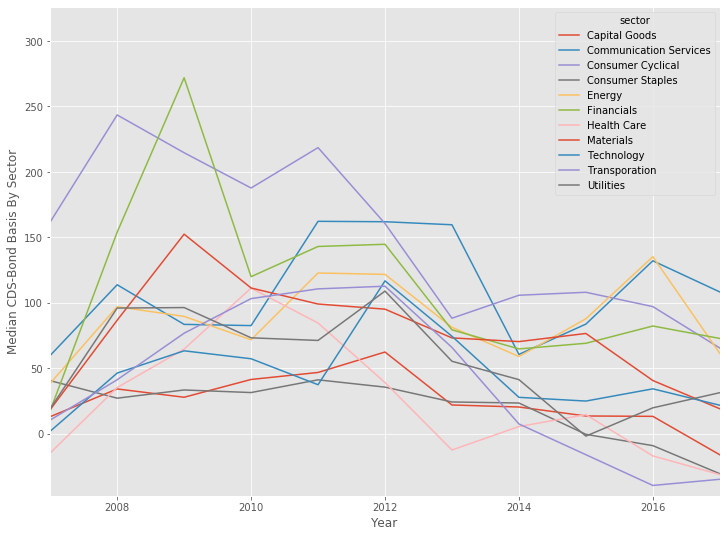

In [28]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,9))
sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack().plot(ax=ax);
plt.ylim(min_median_adjusted, max_median_adjusted)
plt.xlim(2007, 2017)
ax.set_xlabel('Year')
ax.set_ylabel('Median CDS-Bond Basis By Sector')

### A general observation of the data at an aggregate-level reveals the universal tendency for the median CDS-Bond basis to trend downwards over time
* Although, the graph is too noisy and therefore, too cumbersome to indentify individual sector trends- we will refer to a stylised table to accomplish this task

* NOTE: herewithin, the CDS-Bond basis will be simply referred to as 'the basis'

In [10]:
#create a new dataframe which holds the median basis by sector per year across the sample horizon
median_sector_basis_by_sector = np.round(sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack(),2)

In [11]:
median_sector_basis_by_sector

sector,Capital Goods,Communication Services,Consumer Cyclical,Consumer Staples,Energy,Financials,Health Care,Materials,Technology,Transporation,Utilities
year_index,,,,,,,,,,,
2006,24.12,NaN,19.09,27.22,-12.87,9.07,NaN,18.91,7.92,5.63,66.93
2007,12.99,59.78,161.75,40.52,38.44,17.57,-14.76,18.40,1.86,10.43,19.16
2008,34.18,113.78,243.54,27.12,97.03,153.96,35.23,86.67,46.29,41.19,95.97
2009,27.83,83.51,214.68,33.39,89.59,271.97,64.66,152.45,63.31,76.76,96.36
2010,41.42,82.59,187.72,31.42,71.75,119.96,111.24,111.32,57.24,103.21,73.24
2011,46.77,162.26,218.57,41.14,122.78,143.04,84.57,99.07,37.41,110.64,71.24
2012,62.39,161.94,160.57,35.56,121.72,144.72,39.03,95.14,116.75,112.68,108.94
2013,21.92,159.63,88.22,24.22,81.28,79.34,-12.46,73.18,74.42,65.89,55.32
2014,20.37,60.57,105.77,23.43,58.97,64.77,5.44,70.35,27.77,7.43,41.30


#### A full analysis of the trends and accompanying explanations is available in the formal write-up document - linked at the top of this notebook

##### A brief primer on some principal trends are included here for convenience however: 
* There appears to be some aggregate-level macro event which occured around 2012, which temporarily reversed the earlier trend of shrinking basis values. One noteworthy observation is that the effect is significantly more pronounced for typically "riskier" industries, E.G. Technology, Financials and less pronounced for typically safer sectors E.G. Consumer Staples: which appears to be virtually unaffected. 
    * In the write-up, an argument and explanation is made in favour of determining whether the spike in median- and mean basis, which is presented in the write-up- can be causally explained by contagion effects from  2012's Eurozone Crisis. Broadly speaking, the answer is yes. 
    
    
* A more top-level observation is to note the long-run dynamics of the median basis across sectors. Drawing upon the aforementioned sectors above, the more typically "safe" asset classes have a long-run median which is closer to zero (E.G. consumer staples, capital goods) VS. more typically volatile sectors (E.G. Consumer Cyclical, Financials): which have consistently higher bases, as well as exhibit greater volatility. 

### Turning to a broader overview of the distribution of the observations and the dynamics of the basis over time

* Present a simple table which shows how many observations fall into each year and determine the aggregate mean, median and standard deviation values for the entire sample.

* The aim is to largely establish that each year has a sufficient number of observations, such that causal explanations- such as the one presented above about the impacts of the Eurozone Crisis- can be soundly made without concern for other statistical anomalies: small sample-size effects etc. 

In [ ]:
#search for: 

basis_stats_obspercent_yearind

## Illustrating number of positive & negative weeks to descriptive statistics table

* PECDS_VAR_1.24

# REGRESSIONS-PRIMER

* Show a single GVKEY in demonstrating the: ADF, cointegration test, VAR regression, VECM regression, MS-VECM 


* (hyperlink its github location? Or PDF export?) 

# AUGMENTED DICKEY-FULLER (ADF) TEST

### Unit Root Testing / Stationarity Testing
* Fundamentally, it uses an autoregressive model, and optimises the (Bayesian Information Criterion (BIC)) across multiple different lags. NOTE: Other information criterion can also be used, for which there are pros and cons. See full report for an indepth analysis on the choice of BIC over alternatives


* The hypotheses: 
    * Null Hypothesis (H0) = the process can be represented by a unit root (has a time dependent structure / is stationary)
        * If failed to be rejected, implies the series/process has a unit root (it is non-stationary)
    * Alternative Hypothesis (H1) = the process has no unit root (no-time dependent structure); that is, the series is non-stationary
        * Rejecting the H0 - suggests the series does not have a unit root and implies it is stationary
        

* Roughly speaking, the more negative the test statistic, the more likely it is to reject the null hypothesis (the data is stationary)

    
* Additionally, the interpretation of this result must be supported by a threshold p-value; this paper uses a 95% certainty (p-value <= 0.05 will result in rejecting the H0). Similarily, a p-value > 0.05 will indicate a failure to reject H0 and imply the presence of a unit root / non-stationarity


### IMPORTANT : The VECM model & its extensions require the series to not only be non-stationary, but be integrated of the same order; accordingly, all series must be characterised by a unit-root for the regression models to be valid

In [36]:
#make a note on the p-value in the tesT? seems to always be >0.05 if the test.val is rejected (not neg enough AKA unit root)

#is it even valid to use VIX in the ADF test because the result then becomes time-dependent based on the exact sample periods? 


In [ ]:
#possible extensions: DFGLS? 
#Zivot-Andrews (UR test with a structural break in the intercept)


In [ ]:
#FROM: MSVECM_1.02

In [ ]:
#one_percent_cv == un hard-code it

In [51]:
ADF_critical_values_dictionary = list(test_ADF_cds.critical_values.values())

one_percent_cv = ADF_critical_values_dictionary[0]
five_percent_cv = ADF_critical_values_dictionary[1]
ten_percent_cv = ADF_critical_values_dictionary[2]

print("1% ADF CRITICAL VALUE:",  one_percent_cv, '\n'); print("5% ADF CRITICAL VALUE:", five_percent_cv, '\n')
print("10% ADF CRITICAL VALUE:", ten_percent_cv)

1% ADF CRITICAL VALUE: %f -3.4347287139577753 

5% ADF CRITICAL VALUE: -2.8634739225299133 

10% ADF CRITICAL VALUE: -2.5677995973755325


In [52]:
for key, value in test_ADF_cds.critical_values.items():
    print('\t%s: %.3f' % (key, value))

	1%: -3.435
	5%: -2.863
	10%: -2.568


In [56]:
test_ADF_cds.summary()

Test Statistic,-5.087
P-value,0.000
Lags,1


In [ ]:
#sum(list(values_adf)[0:1])

In [ ]:
#add discussion here: 

https://stackoverflow.com/questions/21604498/numpy-cholesky-decomposition-linalgerror
    
    

In [ ]:
#check msvecm_1.02 for table output / latex presentation tables



## maybe scrap equities trading data from this section

* Analyse that seperately, maybe some correlation methods with VIX? 
* Regress on different elements of the firm level ratios + 

### NEED THE GENERAL MARKET RETURN OF S&P 500?


#### SEE FONTANA 2011! for extracting market risk premium from S&P 500 (VIX, GARCH, S&P etc.) 

# VIX/CDS/BOND

* Consider dropping the p-values? 
* How to handle the VIX? 
    * which papers had VIX? 

In [ ]:
#import ADF values here: (instead of hard-coding as below)

In [76]:
#initialise a few lists to append data to from each GVKEY's loop

gvkey_list = []                       #holds the GVKEY
sector_list = []                      #append the sector for each GVKEY (just saves having to re-merge on again later)
optimal_lag_list = []                 #holds the optimal number of lags selected by the BIC
first_date_obs = []                   #holds the first date observation per GVKEY
last_date_obs = []                    #holds the last date observation per GVKEY
time_horizon = []                     #holds the difference between the first and last date observations

stationarity_ts_cds = []              #the test statistic for the CDS series
stationarity_ts_bond = []             #the test statistic for the BOND series
stationarity_ts_vix = []

stationarity_pvalue_cds = []          #the p-value for the CDS series
stationarity_pvalue_bond = []         #the p-value for the BOND series
stationarity_pvalue_vix = []

stationarity_test_res_cds = []        #a list which will hold the significance level (*, **, ***) for publication tables
stationarity_test_res_bond = []
stationarity_test_res_vix = []

stat_test_joint = []                  #will hold the outcome for the joint unit-root test outcome
stat_boolean = []                     #a counter for the number of stationary series in each GVKEY group

problematic_gvkey = []
linalg_errors = 0; value_errors = 0

#THE ADF CRITICAL VALUES - highlighted/calculated above:
one_percent_cv = -3.4347287139577753   
five_percent_cv = -2.8634739225299133 
ten_percent_cv = -2.5677995973755325

#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        #assign the remainder of the data to be callable from data.(variable)
    gvkey_list.append(gvkey)             #append the GVKEY to a list, which keeps the data stored under the appropriate key
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])      #append the respective sector for that GVKEY
    
    #compute the specifics of each GVKEY's date / time horizon
    first_date_obs.append(data.trade_date.min())
    last_date_obs.append(data.trade_date.max())
    time_difference = data.trade_date.max() - data.trade_date.min()
    time_horizon.append(time_difference.days)               #append just the .days aspect of the timedelta variable
    
    #define the appropriate series for the ADF test: 
    cds = data.market_cds_spread         
    pecds = data.pecds
    vix = data.cboe_vix
    
    #the VAR model package requires the data be structured in a particular way; np.column stack is the fastest method
    data = np.column_stack((cds, pecds)) 
    
    #the VAR model construction is necessary for computing the BIC
    model = smt.VAR(data)  

    #compute the optimised BIC value from [model] which holds the vector autoregression model per GVKEY
    try:
        #for daily data, a maximum lag length is imposed (5 trading days, roughly equivalent to one trading week)
        bic_selected_lag = model.select_order(maxlags=5).bic 
        optimal_lag_list.append(bic_selected_lag)                  #store the optimised BIC result per GVKEY
        
        #ADF test - plugging in the bic selected lag length to run a unique length ADF test per GVKEY, per instrument
        test_ADF_cds = ADF(cds, lags=bic_selected_lag)   
        test_ADF_bond = ADF(pecds, lags=bic_selected_lag)  
        test_ADF_vix = ADF(vix, lags=bic_selected_lag)
        
        #store the test statistic & p-value for each instrument's ADF test result, for each GVKEY (rounded to 4 decimals)
        stationarity_ts_cds.append(np.round(test_ADF_cds.stat,4))    
        stationarity_ts_bond.append(np.round(test_ADF_bond.stat,4))     
        stationarity_ts_vix.append(np.round(test_ADF_vix.stat,4))
        
        stationarity_pvalue_cds.append(np.round(test_ADF_cds.pvalue,4))    
        stationarity_pvalue_bond.append(np.round(test_ADF_bond.pvalue,4))
        stationarity_pvalue_vix.append(np.round(test_ADF_vix.pvalue,4))
        
        ##OPTIONAL
        #this part reads the test stat per GVKEY / instrument and assigns the appropriate (*) per its significance level
        #E.G. > 99% significance is commonly denoted as [test_statistic]*** in publication regression tables
        
        #CDS ADF LATEX TABLE CONSTRUCTION
        if test_ADF_cds.stat < one_percent_cv:
            stationarity_test_res_cds.append("***")   
        elif test_ADF_cds.stat < five_percent_cv:
            stationarity_test_res_cds.append("**")    ## The 1% & 5% significance would reject H0
        elif test_ADF_cds.stat < ten_percent_cv:
            stationarity_test_res_cds.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_cds.append(" ")  

        #repeat for BONDS:
        if test_ADF_bond.stat < one_percent_cv:
            stationarity_test_res_bond.append("***")
        elif test_ADF_bond.stat < five_percent_cv:
            stationarity_test_res_bond.append("**")   ## The 1% & 5% significance would reject H0
        elif test_ADF_bond.stat < ten_percent_cv:
            stationarity_test_res_bond.append("*")    ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_bond.append(" ")
            
            
        #VIX ADF LATEX TABLE CONSTRUCTION
        if test_ADF_vix.stat < one_percent_cv:
            stationarity_test_res_vix.append("***")   
        elif test_ADF_vix.stat < five_percent_cv:
            stationarity_test_res_vix.append("**")    ## The 1% & 5% significance would reject H0
        elif test_ADF_vix.stat < ten_percent_cv:
            stationarity_test_res_vix.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_vix.append(" ")  
                    
        
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (test_ADF_bond.stat > five_percent_cv and test_ADF_cds.stat > five_percent_cv):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            stat_test_joint.append("BOND/CDS Both Have Unit Root")
            stat_boolean.append(int(1))
        else: 
            stat_test_joint.append("Cannot Reject H0")
            stat_boolean.append(int(2))
        
    # A linear-algebra error could be caused by market factors which have created highly erratic basis behaviour
    # This could be caused by a firm nearing bankruptcy where its basis deviates excessively far from par
    #accordingly, the leading minor of the array is not positive definite is akin to taking the square root of a negative number
    except np.linalg.LinAlgError as lae:
        problematic_gvkey.append(gvkey)                                 #append problem GVKEY to seperate list
        print("LinAlgError: Row: {}, Reason : {} ".format(i, lae), "SECTOR: ", sector_string.iloc[0])
      
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        optimal_lag_list.append(np.nan)
        stat_test_joint.append("LinAlg_Error")
        
        stationarity_test_res_cds.append("_LAE")
        stationarity_test_res_bond.append("_LAE")
        stationarity_test_res_vix.append("_LAE")
        
        stationarity_ts_cds.append(np.nan)
        stationarity_ts_bond.append(np.nan)
        stationarity_ts_vix.append(np.nan)
        
        stationarity_pvalue_cds.append(np.nan)
        stationarity_pvalue_bond.append(np.nan)
        stationarity_pvalue_vix.append(np.nan)
        
        linalg_errors += 1
        continue
    
    #some series may have encounted some errors with a constant, thus adding a constant to the equation is invalid
    #this occurs due to poor liquidity in some markets, resulting in long periods of near-identical price quotes
    except (ValueError) as ve:
        problematic_gvkey.append(gvkey)
        print("ValueError: Row: {}, Reason : {} ".format(i, ve), "SECTOR:", sector_string.iloc[0])
        
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        optimal_lag_list.append(np.nan)
        stat_test_joint.append("Value_Error")
        
        stationarity_test_res_cds.append("_VE")
        stationarity_test_res_bond.append("_VE")
        stationarity_test_res_vix.append("_VE")        
        
        stationarity_ts_cds.append(np.nan)
        stationarity_ts_bond.append(np.nan)
        stationarity_ts_vix.append(np.nan)
        
        stationarity_pvalue_cds.append(np.nan)
        stationarity_pvalue_bond.append(np.nan)
        stationarity_pvalue_vix.append(np.nan) 
        
        value_errors += 1
        continue  
        
#this section combines the test-statistic itself with the appropriate (*, **, ***) into one cell for the final DF
cds_sig = ["{}{}".format(stationarity_ts_cds, stationarity_test_res_cds) for stationarity_ts_cds, stationarity_test_res_cds in zip(stationarity_ts_cds, stationarity_test_res_cds)]
bond_sig = ["{}{}".format(stationarity_ts_bond, stationarity_test_res_bond) for stationarity_ts_bond, stationarity_test_res_bond in zip(stationarity_ts_bond, stationarity_test_res_bond)]  
vix_sig = ["{}{}".format(stationarity_ts_vix, stationarity_test_res_vix) for stationarity_ts_vix, stationarity_test_res_vix in zip(stationarity_ts_vix, stationarity_test_res_vix)]        

#the final DF constructor; the .T is to transpose to a more visually-friendly vertically orientated DF
df_stat_cdsbond_results = pd.DataFrame(data=(gvkey_list, sector_list, cds_sig, stationarity_pvalue_cds,
                                             bond_sig, stationarity_pvalue_bond,
                                             vix_sig, stationarity_pvalue_vix,
                                             stat_test_joint, optimal_lag_list,
                                            first_date_obs, last_date_obs, time_horizon)).T

#dont think the boolean is needed? can read col names fine? 

#rename the columns for better readability
df_stat_cdsbond_results.columns = ['gvkey', 'sector', 'CDS', 'CDS_pval', 'Bond', 'BOND_pval',
                                   'VIX', 'VIX_pval',
                                   'Joint_Test_Outcome', 'bic_lag',
                                  'date_start','date_end','length_days'] 

#change to tabulate? 
print('\n', " Linear Algebra Errors #", linalg_errors, '\n', " Value Errors #", value_errors, '\n', " Total Errors #:", 
     (linalg_errors + value_errors))

ValueError: Row: 105, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Consumer Cyclical
ValueError: Row: 109, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Materials
ValueError: Row: 123, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Financials
ValueError: Row: 158, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Capital Goods
LinAlgError: Row: 179, Reason : 1-th leading minor of the array is not positive definite  SECTOR:  Consumer Cyclical
ValueError: Row: 205, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Financials
ValueError: Row: 212, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  SECTOR: Consumer Cyclical
LinAlgError: Row: 244, Reason : 1-th leading minor of the array is not positive definite  SECTOR:  Consumer Cyclical
ValueError: 

In [77]:
df_stat_cdsbond_results

,gvkey,sector,CDS,CDS_pval,Bond,BOND_pval,VIX,VIX_pval,Joint_Test_Outcome,bic_lag,date_start,date_end,length_days
0,1045,Transporation,-1.0934,0.7177,-4.4743***,0.0002,-2.9543**,0.0394,Cannot Reject H0,1,2009-09-24,2014-05-30,1709
1,1078,Health Care,-1.357,0.6027,-1.2011,0.6731,-2.4359,0.1319,BOND/CDS Both Have Unit Root,1,2008-03-17,2010-09-30,927
2,1161,Technology,-2.0657,0.2585,-2.2804,0.1784,-5.6409***,0,BOND/CDS Both Have Unit Root,2,2008-04-10,2017-06-30,3368
3,1209,Materials,-1.7596,0.4007,-1.5329,0.5172,-4.4417***,0.0003,BOND/CDS Both Have Unit Root,1,2011-07-28,2017-06-30,2164
4,1300,Capital Goods,-2.5216,0.1103,-2.5023,0.1149,-3.9176***,0.0019,BOND/CDS Both Have Unit Root,2,2007-12-14,2017-03-01,3365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,175263,Consumer Cyclical,-3.1151**,0.0255,-4.7835***,0.0001,-2.2484,0.1892,Cannot Reject H0,1,2009-02-23,2010-02-26,368
387,176404,Communication Services,-2.8574*,0.0505,-2.3013,0.1715,-3.6837***,0.0043,BOND/CDS Both Have Unit Root,2,2008-01-28,2016-04-29,3014
388,176760,Materials,-1.8314,0.365,-1.301,0.6287,-3.1277**,0.0246,BOND/CDS Both Have Unit Root,2,2007-12-03,2017-06-29,3496
389,179657,Capital Goods,nan_VE,NaN,nan_VE,NaN,nan_VE,NaN,Value_Error,NaN,2014-07-16,2016-07-15,730


In [56]:
#trnasform this into seperate DF? (with reason, #obs, date etc.?)
problematic_gvkey
#should match ZA test? 

[5671,
 5862,
 6653,
 7991,
 8551,
 10187,
 10443,
 12459,
 25180,
 25495,
 30219,
 30671,
 64768,
 64891,
 137024,
 179657]

## REORGANISE RESULTS PRESENTATION

In [79]:
#isolate each group into a seperate DF
unitroot_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='BOND/CDS Both Have Unit Root']
stationary_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='Cannot Reject H0']

#group results by sector: 
unitroot_gvkeys_adf_results = unitroot_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})
stationary_gvkeys_adf_results = stationary_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})

#rename for better readability / the future titles
unitroot_gvkeys_adf_results = unitroot_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Unit Root', 'Unit_Roots')})
stationary_gvkeys_adf_results= stationary_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Stationary', 'Stat_Series')}) 

### BRIEF RUNDOWN:
* Unit Root GVKEYS: 259
* Stationary GVKEYS: 116
    * Total GVKEYS usable in regressions: (259 + 116) == 375
    

* Total Error GVKEYS (14 Value Errors + 2 Linear Algebra Errors == 16) 
* Total Analysed GVKEY groups (375 + 16) = 391

In [80]:
sector_adf_results = pd.concat([unitroot_gvkeys_adf_results, stationary_gvkeys_adf_results], axis=1)

#sector_adf_results= sector_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Unit Root', 'size')})

sector_adf_results = sector_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome','Unit_Roots'),
                                                       ('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome', 'Stationary')})

In [95]:
sector_adf_results
#stationary is 2nd column (==116)

Joint_Test_Outcome           
                               Unit Roots Unit Roots
sector                                              
Capital Goods                          21         10
Communication Services                  6          4
Consumer Cyclical                      50         13
Consumer Staples                       28         18
Energy                                 28          6
Financials                             30         18
Health Care                            23          4
Materials                              25         19
Technology                             22          6
Transporation                           7          7
Utilities                              16         11

In [122]:
sector_adf_results.index.unique(level=1)

IndexError: Too many levels: Index has only 1 level, not 2

# fix multi-index? 

In [120]:
sector_adf_results.columns.set_levels(['Unit Roots', 'Stationary'], level=1, inplace=True)
sector_adf_results

Joint_Test_Outcome           
                               Unit Roots Unit Roots
sector                                              
Capital Goods                          21         10
Communication Services                  6          4
Consumer Cyclical                      50         13
Consumer Staples                       28         18
Energy                                 28          6
Financials                             30         18
Health Care                            23          4
Materials                              25         19
Technology                             22          6
Transporation                           7          7
Utilities                              16         11

In [ ]:
#displaying only stationary observations

#stationary only variables for 1% / 5% significance for both series
#statationary_cdsbonds_df = df_stat_cdsbond_results.loc[((df_stat_cdsbond_results.stationarity_test_res_bond=='***') | (df_stat_cdsbond_results.stationarity_test_res_bond=='**')) & ((df_stat_cdsbond_results.stationarity_test_res_cds=='***') | (df_stat_cdsbond_results.stationarity_test_res_cds=='**'))]

#USE: 
stationary_gvkeys

#for the VAR in levels

# ZIVOT-ANDREWS
### "The Zivot-Andrews structural-break unit-root test" 


* Test for unit root in a univariate process in the presence of serial correlation + single structural break 
* https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ZivotAndrews.html#arch.unitroot.ZivotAndrews


* Should I test this on: main DF? (probS) VS. the unit-root only sub-sample?

In [ ]:
#method == BIC
#trend = 't'

In [39]:
#test DF

gvkey_1045 = sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==1045]

In [ ]:
#import the above loop here: compare results

#H0 = unit root with a single structural break 

In [41]:
#E.G. 
gvkey_1045_za = ZivotAndrews(gvkey_1045['market_cds_spread'], trend='c',trim=0.15, max_lags=5, method='BIC')
#trend
gvkey_1045_za.summary()

Test Statistic,-22.111
P-value,0.000
Lags,0


In [8]:
gvkey_1045_za = ZivotAndrews(gvkey_1045['market_cds_spread'], trend='c',trim=0.15, max_lags=5, method='BIC')
#constant
gvkey_1045_za.summary()

Test Statistic,-22.111
P-value,0.000
Lags,0


In [42]:
gvkey_1045_za = ZivotAndrews(gvkey_1045['market_cds_spread'], trend='ct',trim=0.15, max_lags=5, method='BIC')
#constant + trend
gvkey_1045_za.summary()

Test Statistic,-27.478
P-value,0.000
Lags,0


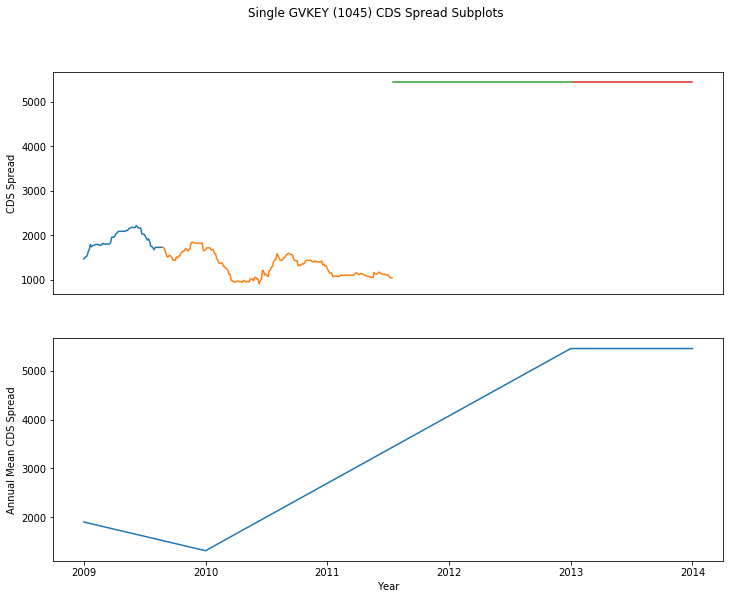

In [43]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('Single GVKEY (1045) CDS Spread Subplots ')

gvkey_1045.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_1045.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');
                       

In [46]:
#gvkey_1045[250:300]
#276 to 277: 3Y gap (massive CDS Spike from graph)

In [ ]:
#highlight the sudden "spike" and how a linear test along would fail the ZA test

In [47]:
#see(gvkey_1045_za)

In [53]:
gvkey_1045_za.critical_values

{'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}

In [65]:
gvkey_1045_za.critical_values.items()

dict_items([('1%', -5.03421), ('5%', -4.4058), ('10%', -4.13678)])

In [69]:
ZA_critical_values_dictionary = list(gvkey_1045_za.critical_values.values())

za_one_percent_cv = ZA_critical_values_dictionary[0]
za_five_percent_cv = ZA_critical_values_dictionary[1]
za_ten_percent_cv = ZA_critical_values_dictionary[2]

print(" ONE % ZA CRITICAL VALUE:", za_one_percent_cv, '\n', "FIVE % ZA CRITICAL VALUE:", za_five_percent_cv, '\n', 
      "TEN % ZA CRITICAL VALUE:", za_ten_percent_cv)

 ONE % ZA CRITICAL VALUE: -5.03421 
 FIVE % ZA CRITICAL VALUE: -4.4058 
 TEN % ZA CRITICAL VALUE: -4.13678


## Zivot-Andrews Loop

In [6]:
#create list for the general items
gvkey_list = []                        #holds the GVKEY
sector_list = []                       #append the sector for each GVKEY (just saves having to re-merge on again later)
first_date_obs = []                    #holds the first date observation per GVKEY
last_date_obs = []                     #holds the last date observation per GVKEY
time_horizon = []                      #holds the difference between the first and last date observations
group_size = []                        #hold the number of observations (trades) per GVKEY
size_discrepancy = []                  #hold the difference between #obs and (first trade - last trade) dates (a comparison)

#create lists for items specific to the ZA test
unitroot_ts_cds = []                   #the test statistic for the CDS series
unitroot_pvalue_cds = []               #the p-value for the CDS series
unitroot_test_res_cds = []             #a list which will hold the significance level (*, **, ***) for publication tables
group_stddev = []
outcome_string = []

#create a seperate DF to hold details about the probematic GVKEY groups & their characteristics 
problematic_gvkey = []
problematic_first_date_obs = []                   #holds the first date observation per GVKEY
problematic_last_date_obs = []                    #holds the last date observation per GVKEY
problematic_time_horizon = []                     #holds the difference between the first and last date observations
problematic_sector = []
problematic_size_discrep = []                     #holds the difference in trades vs (first - last date)
problematic_cds_stddev = []                       #compare against that group's standard_deviation (likely constant error)
problem_argument_instance = []                   #hold the string argument of the errors
infeasible_test_exceptions_counter = 0            #count the number of error instances

#THE ZA-TEST CRITICAL VALUES - highlighted/calculated above: (they don't change so fine to hard code in)
one_percent_cv = -5.27644   
five_percent_cv = -4.81067 
ten_percent_cv = -4.56618

#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        #assign the remainder of the data to be callable from data.(variable)
    gvkey_list.append(gvkey)             #append the GVKEY to a list, which keeps the data stored under the appropriate key
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])      #append the respective sector for that GVKEY
    
    
    #compute the specifics of each GVKEY's date / time horizon
    first_date_obs.append(data.trade_date.min())
    last_date_obs.append(data.trade_date.max())
    time_difference = data.trade_date.max() - data.trade_date.min()
    time_horizon.append(time_difference.days)               #append just the .days aspect of the timedelta variable
    
    #define the appropriate series for the ADF test: 
    cds_za = data.market_cds_spread      
    group_stddev.append(np.round(cds_za.std(),4))

    #bic is optimised within the test (see notes)

    try:
        #run the ZA-test
        za_test_cds = ZivotAndrews(cds_za, trend='c', trim=0.15, max_lags=5, method='BIC')
        group_size.append(za_test_cds.nobs)
        size_discrepancy.append(int(za_test_cds.nobs) - int(time_difference.days))
        
        #number will always be negative as there are holidays etc. which mean total days is always > #trading days
          
        #store the test statistic & p-value for the ZA-TEST, by GVKEY (rounded to 4 decimals)
        unitroot_ts_cds.append(np.round(za_test_cds.stat,4))    
        unitroot_pvalue_cds.append(np.round(za_test_cds.pvalue,4))    

        
        #CDS ZA-TEST LATEX TABLE CONSTRUCTION
        if za_test_cds.stat < one_percent_cv:
            unitroot_test_res_cds.append("***")   
        elif za_test_cds.stat < five_percent_cv:
            unitroot_test_res_cds.append("**")    ## The 1% & 5% significance would reject H0
        elif za_test_cds.stat < ten_percent_cv:
            unitroot_test_res_cds.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            unitroot_test_res_cds.append(" ")     #Fail to reject the H0 at any level less than 0.10% significance
            
              
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (za_test_cds.stat > five_percent_cv or za_test_cds.pvalue > 0.05):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            outcome_string.append("unit root & one structural break")
        else: 
            outcome_string.append("process is trend/break stationary")


    except (InfeasibleTestException) as ite:
        #fill in the lists for the main_DF to maintain list to DF structuring 
        unitroot_ts_cds.append(np.nan)
        unitroot_pvalue_cds.append(np.nan)
        unitroot_test_res_cds.append("_ITE")
        outcome_string.append("ITE_ERROR")
        
        #populate items for the "problem" DF
        problematic_gvkey.append(gvkey)
        problematic_sector.append(sector_string.iloc[0]) 
        problematic_cds_stddev.append(cds_za.std())
        
        #populate date items
        problematic_first_date_obs.append(data.trade_date.min())
        problematic_last_date_obs.append(data.trade_date.max())
        problematic_time_difference = data.trade_date.max() - data.trade_date.min()
        problematic_time_horizon.append(time_difference.days) 
        problematic_size_discrep.append(int(cds_za.shape[0]) - int(time_difference.days)) #acquire the 'size' of the group 
    
        #print just the first instance of exception/error, and append details to the seperate DF
        problematic_instance_string = str(ite.args)
        if problematic_instance_string not in problem_argument_instance:
            print("InfeasibleTestException: Row: {}, Reason : {} ".format(i, ite))
            problem_argument_instance.append(problematic_instance_string)
        
        infeasible_test_exceptions_counter += 1
        print("GVKEY:", gvkey, "Another InfeasibleTestException: Row: {}".format(i), "SECTOR:", sector_string.iloc[0])
        continue          
        
        
#this section combines the test-statistic itself with the appropriate (*, **, ***) into one cell for the final DF
cds_za_sig = ["{}{}".format(unitroot_ts_cds, unitroot_test_res_cds) for unitroot_ts_cds, unitroot_test_res_cds in zip(unitroot_ts_cds, unitroot_test_res_cds)]


#the final DF constructor; the .T is to transpose to a more visually-friendly vertically orientated DF
df_za_results = pd.DataFrame(data=(gvkey_list, sector_list, cds_za_sig,  unitroot_pvalue_cds,
                                             outcome_string, first_date_obs, last_date_obs, time_horizon,
                                  group_stddev, size_discrepancy)).T

#rename the columns for better readability
df_za_results.columns = ['gvkey', 'sector', 'CDS_ZA_Test_Statistic', 'CDS_pval', 'Outcome',
                                  'date_start','date_end','length_days','std_dev','size_dif']


#construct problem DF
za_problem_df = pd.DataFrame(data=(problematic_gvkey, problematic_first_date_obs, problematic_last_date_obs,
                                   problematic_time_horizon, problematic_size_discrep, 
                                   problematic_cds_stddev, problematic_sector)).T

za_problem_df.columns = ['gvkey','first_obs_date','last_obs_date','length_days', 
                         'size_dif','group_cds_stddev', 'problem_sector']
                                   

print("Infeasible Test Exceptions Count:", infeasible_test_exceptions_counter)

C:\Users\JasonSpano\anaconda3\lib\site-packages\arch\unitroot\unitroot.py:1450: RuntimeWarning: invalid value encountered in sqrt
  return b / sqrt(diag(sigma2 * xpxi))


InfeasibleTestException: Row: 105, Reason : The maximum lag you are considering (5) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models. 
GVKEY: 5671 Another InfeasibleTestException: Row: 105 SECTOR: Consumer Cyclical
GVKEY: 5862 Another InfeasibleTestException: Row: 109 SECTOR: Materials
GVKEY: 6653 Another InfeasibleTestException: Row: 123 SECTOR: Financials
GVKEY: 7991 Another InfeasibleTestException: Row: 158 SECTOR: Capital Goods
InfeasibleTestException: Row: 179, Reason : The maximum lag you are considering (5) results in an ADF regression with a
singular regressor matrix after including 2 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally cons

In [7]:
df_za_results

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif
0,1045,Transporation,-22.1113***,0,process is trend/break stationary,2009-09-24,2014-05-30,1709,2014.14,-1163
1,1078,Health Care,-3.2055,0.838,unit root & one structural break,2008-03-17,2010-09-30,927,22.7526,-307
2,1161,Technology,-2.5922,0.9788,unit root & one structural break,2008-04-10,2017-06-30,3368,395.927,-1483
3,1209,Materials,-3.4523,0.7097,unit root & one structural break,2011-07-28,2017-06-30,2164,12.6212,-693
4,1300,Capital Goods,-4.1703,0.2542,unit root & one structural break,2007-12-14,2017-03-01,3365,19.0918,-991
...,...,...,...,...,...,...,...,...,...,...
386,175263,Consumer Cyclical,-2.102,0.9953,unit root & one structural break,2009-02-23,2010-02-26,368,29.0927,-103
387,176404,Communication Services,-3.7509,0.5127,unit root & one structural break,2008-01-28,2016-04-29,3014,59.4247,-922
388,176760,Materials,-4.1946,0.2416,unit root & one structural break,2007-12-03,2017-06-29,3496,187.067,-1736
389,179657,Capital Goods,nan_ITE,NaN,ITE_ERROR,2014-07-16,2016-07-15,730,0,-207


In [8]:
za_results_trendbreak_stat = df_za_results.loc[df_za_results.Outcome=='process is trend/break stationary']
za_results_trendbreak_stat

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif
0,1045,Transporation,-22.1113***,0,process is trend/break stationary,2009-09-24,2014-05-30,1709,2014.14,-1163
13,1704,Technology,-5.2397**,0.0123,process is trend/break stationary,2011-06-01,2017-06-15,2206,16.6373,-1585
15,1794,Energy,-4.9981**,0.029,process is trend/break stationary,2011-06-02,2016-08-31,1917,56.1296,-1233
16,1913,Capital Goods,-33.7787***,0,process is trend/break stationary,2007-01-16,2017-06-29,3817,29.8273,-2779
20,1988,Capital Goods,-6.6215***,0.0002,process is trend/break stationary,2010-09-02,2017-06-29,2492,34.5626,-1411
...,...,...,...,...,...,...,...,...,...,...
380,163921,Energy,-6.8601***,0,process is trend/break stationary,2010-07-14,2017-06-30,2543,26.3856,-1819
381,165264,Financials,-7.7925***,0,process is trend/break stationary,2011-05-16,2017-06-21,2228,19.118,-1168
382,165675,Technology,-4.8291**,0.0479,process is trend/break stationary,2009-08-19,2017-06-30,2872,37.5454,-819
383,174130,Communication Services,-4.8401**,0.0467,process is trend/break stationary,2007-06-04,2009-06-01,728,95.4403,-207


In [9]:
len(za_results_trendbreak_stat)

115

In [10]:
za_results_unitroot_sbreak = df_za_results.loc[df_za_results.Outcome=='unit root & one structural break']
za_results_unitroot_sbreak

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif
1,1078,Health Care,-3.2055,0.838,unit root & one structural break,2008-03-17,2010-09-30,927,22.7526,-307
2,1161,Technology,-2.5922,0.9788,unit root & one structural break,2008-04-10,2017-06-30,3368,395.927,-1483
3,1209,Materials,-3.4523,0.7097,unit root & one structural break,2011-07-28,2017-06-30,2164,12.6212,-693
4,1300,Capital Goods,-4.1703,0.2542,unit root & one structural break,2007-12-14,2017-03-01,3365,19.0918,-991
5,1356,Materials,-3.1069,0.8761,unit root & one structural break,2007-01-16,2016-10-31,3576,162.281,-1252
...,...,...,...,...,...,...,...,...,...,...
384,174490,Communication Services,-4.6371*,0.0839,unit root & one structural break,2010-08-02,2013-08-30,1124,82.4387,-319
386,175263,Consumer Cyclical,-2.102,0.9953,unit root & one structural break,2009-02-23,2010-02-26,368,29.0927,-103
387,176404,Communication Services,-3.7509,0.5127,unit root & one structural break,2008-01-28,2016-04-29,3014,59.4247,-922
388,176760,Materials,-4.1946,0.2416,unit root & one structural break,2007-12-03,2017-06-29,3496,187.067,-1736


## SINGLE GVKEY: QUICK VISUALISATION TAB
#### Input GVKEY - visualise individual test result & graph CDS to view potential break points

In [33]:
#insert GVKEY, view individual test results

gvkey_selection = 1300

ZivotAndrews(sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==gvkey_selection]['market_cds_spread'], 
             trend='t',trim=0.15, max_lags=5, method='BIC').summary()

Test Statistic,-4.038
P-value,0.125
Lags,2


In [38]:
#view that GVKEY's standard deviation

print("GVKEY ({}) STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==gvkey_selection]['market_cds_spread'].std(),4))

GVKEY (1300) STANDARD DEVIATION IS:  19.0918


 COMPANY ==  HONEYWELL INTERNATIONAL INC 
 SECTOR ==   Capital Goods


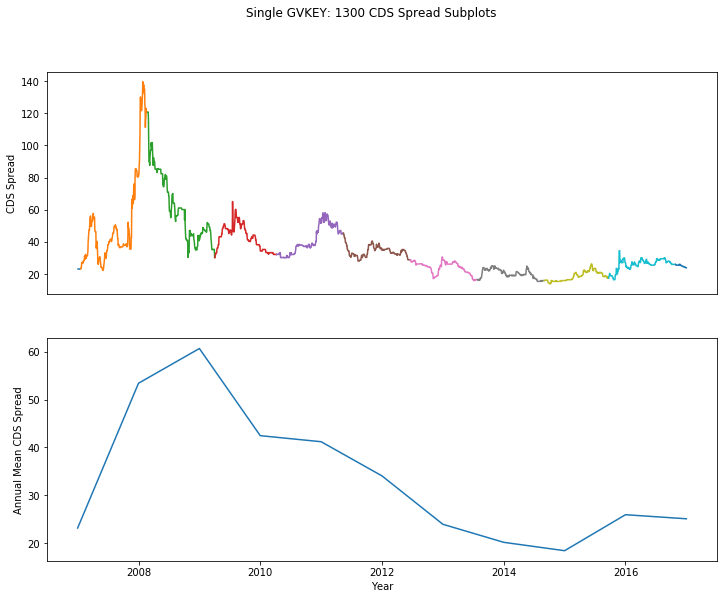

In [28]:
#insert GVKEY, view evolution of the key's CDS series & annual mean changes
gvkey_selection = 1300

gvkey_group_df = sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('Single GVKEY: {} CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');
                       

## CREATE LOOP WITH THE (3) different ZA-tests? (TABLE) with ADF? 

## PROBLEM GVKEYS

In [30]:
za_problem_df
#all have nearly == 0 STD DEV

,gvkey,first_obs_date,last_obs_date,length_days,size_dif,group_cds_stddev,problem_sector
0,5671,2009-06-15,2010-09-30,472,-133,3.70028e-13,Consumer Cyclical
1,5862,2016-04-01,2017-06-28,453,-129,2.9889e-13,Materials
2,6653,2013-05-21,2015-07-15,785,-223,0,Financials
3,7991,2008-01-16,2010-09-30,988,-378,3.6623e-13,Capital Goods
4,8551,2016-12-15,2017-06-30,197,-55,0.000236513,Consumer Cyclical
5,10187,2008-02-04,2008-11-05,275,-77,2.67129e-14,Financials
6,10443,2008-11-17,2010-09-30,682,-193,0,Consumer Cyclical
7,12459,2016-09-15,2017-06-30,288,-81,4.27359e-13,Consumer Cyclical
8,25180,2015-12-02,2017-06-29,575,-163,8.53688e-13,Capital Goods
9,25495,2012-04-16,2017-06-30,1901,-692,2.50215e-12,Utilities


In [ ]:
#what is the distribution of sectors in the total DF? 

sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack()

In [98]:
sorted_alldata_df_final.groupby(['sector','gvkey']).size()

sector         gvkey 
Capital Goods  1300      2374
               1913      1038
               1988      1081
               2285       929
               2393       523
                         ... 
Utilities      25495     1209
               25627     1876
               65092     1731
               135990    1932
               140977     267
Length: 388, dtype: int64

In [93]:
#check earlier code for improvement (firm size by sector? )
sorted_alldata_df_final.groupby(['sector']).size()

sector
Capital Goods             40115
Communication Services    15265
Consumer Cyclical         75948
Consumer Staples          66417
Energy                    42617
Financials                50476
Health Care               31186
Materials                 52417
Technology                33902
Transporation             18482
Utilities                 31422
dtype: int64

In [9]:
sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==5862]['market_cds_spread'].std()

2.9888955478472275e-13

In [112]:
sorted_alldata_df_final.groupby('gvkey').size()

gvkey
1045       546
1078       620
1161      1885
1209      1471
1300      2374
          ... 
175263     265
176404    2092
176760    1760
179657     523
179700    1498
Length: 391, dtype: int64

# REGRESSIONS

## VAR MODELS / GRANGER-CAUSALITY TEST
* VAR/GCT in-levels (stationary series)
* VAR/GCT in-differences (unit-root series')
    * GCT test in the VAR framework: to be compared (authenticed by) the VECM framework

* do some sort of impulse response check? (See Econometrics with python / see the online docs)?



* VECM MODELING: 
    * (JOHANSEN?) Cointegration Rank + appropriate LAG length (BIC) from 'vecm_model_order'
        * Could try the: Phillips_Ouliaris cointegration framework? from arch.readthedocs
    * Can apply wald_test among the variables (instantaneous causality) + residuals_autocorrelations (test_whiteness)
    
* VECM MODEL + the price discovery measures 


* MS-VECM MODEL + regime  switching coefficients etc. 



#### Reapply process to: 
* Apply to weekly series? 
* ADF test / Zivot-Andrews >> VAR/GCT (overwhelming non-stat?) >> VECM > MS-VECM